***Load modules*** 
This will require amtrack repo in the right path I use environment variables but feel free to do something better.
Normally all the required packages are indicated, if some are missing, please add them.
If you also want to create a "freeze" or a poetry thing to have an easier installation of the environment please do so.


In [15]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import get_dates_datetime, get_dirname, temp_path, get_data_info, update_plate_info, \
get_current_folders, get_folders_by_plate_id


import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import from_sparse_to_graph, generate_nx_graph, sparse_to_doc
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, Edge,Node, plot_raw_plus
from amftrack.pipeline.paths.directory import run_parallel_transfer, find_state, directory_scratch, directory_project, directory_archive
import dropbox
from amftrack.transfer.functions.transfer import upload, zip_file, sync_fold
from subprocess import call
from tqdm.autonotebook import tqdm
from time import time_ns
import subprocess
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from amftrack.util.sys import get_dates_datetime, get_dirname, temp_path
temp_path


'/data/temp'

***choose the path of interest***
I mounted sun on my linux computer at AMOLF. Please feel free to do so on yours as well. I can send you the command. 
Otherwise, if you have the folders locally, just indicate the path.
Finally you can also simply ssh to my computer and run things from there.

In [4]:
directory = r'/mnt/sun-temp/TEMP/PRINCE_analysis/'

update_plate_info(directory,local=True)
all_folders = get_current_folders(directory,local=True)
# len(folders)

analysed:   0%|          | 0/26 [00:00<?, ?it/s]

***Choose the folder you're interested in***

In [5]:
folders = all_folders.loc[all_folders['folder']=='20220420_0834_Plate12']

In [5]:
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_masked_compressed.mat,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder
5,/mnt/sun-temp/TEMP/PRINCE_analysis/20220420_08...,1019,12,'Carrot','C2','001P100N200C','Y','-',20220419,25,...,False,False,False,False,False,False,False,False,"20.04.2022, 08:34:",20220420_0834_Plate12


These are local adaptations of functions for running things on the supercomputer. So better to keep them in the notebook at this stage.

In [6]:
path_code = os.getenv('HOME')+"/pycode/MscThesis/"

def make_stitching_loop(directory,dirname,op_id):
    a_file = open(f'{path_code}amftrack/pipeline/scripts/stitching_loops/stitching_loop.ijm',"r")

    list_of_lines = a_file.readlines()

    list_of_lines[4] = f'mainDirectory = \u0022{directory}\u0022 ;\n'
    list_of_lines[29] = f'\t if(startsWith(list[i],\u0022{dirname}\u0022)) \u007b\n'
    file_name = f'{os.getenv("TEMP")}/stitching_loops/stitching_loop{op_id}.ijm'
    a_file = open(file_name, "w")

    a_file.writelines(list_of_lines)

    a_file.close()
    
def run_stitch(directory, folders):
    folder_list = list(folders['folder'])
    folder_list.sort()    
    with tqdm(total=len(folder_list), desc="stitched") as pbar:
        for folder in folder_list:
            op_id = time_ns()
            im = imageio.imread(f'{directory}/{folder}/Img/Img_r03_c05.tif')
            for x in range(1,11):
                for y in range(1,16):
                    strix= str(x) if x>=10 else f'0{x}'
                    striy= str(y) if y>=10 else f'0{y}'
                    path = f'{directory}/{folder}/Img/Img_r{strix}_c{striy}.tif'
                    # print(striy,path,os.path.getsize(path))
                    if not os.path.isfile(path):
                        f = open(path, 'w')
                    if os.path.getsize(path)==0:
                        imageio.imwrite(path,im*0)
            make_stitching_loop(directory,folder,op_id)
            command = [os.getenv('HOME')+'/Fiji.app/ImageJ-linux64','--mem=8000m','--headless','--ij2','--console','-macro',f'{os.getenv("TEMP")}/stitching_loops/stitching_loop{op_id}.ijm']
            print(' '.join(command))
            process = subprocess.run(command)
            pbar.update(1)
            
def run_parallel(code, args, folders):
    op_id = time_ns()
    folders.to_json(f'{os.getenv("TEMP")}/{op_id}.json')# temporary file
    folder_list = list(folders['folder'])
    folder_list.sort()  
    args_str = [str(arg) for arg in args]
    arg_str = " ".join(args_str)
    with tqdm(total=len(folder_list), desc="stitched") as pbar:
        for index,folder in enumerate(folder_list):
            command = ['python',f'{path_code}amftrack/pipeline/scripts/image_processing/{code}']+args_str+[f'{op_id}',f'{index}']
            print(' '.join(command))
            process = subprocess.run(command)
            pbar.update(1)

***Stitch the folders you're interested in***

should take about 20mins

In [19]:
run_stitch(directory,folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ipausers/bisot/Fiji.app/ImageJ-linux64 --mem=8000m --headless --ij2 --console -macro /home/ipausers/bisot/temp//stitching_loops/stitching_loop1648810566105623944.ijm


Java HotSpot(TM) 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


20220330_2357_Plate19/
(Fri Apr 01 12:58:52 CEST 2022): Stitching the following files:
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_r01_c01.tif' Imp: 'null' Offset: (0.0, 0.0)
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_r01_c02.tif' Imp: 'null' Offset: (3276.0, 0.0)
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_r01_c03.tif' Imp: 'null' Offset: (6552.0, 0.0)
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_r01_c04.tif' Imp: 'null' Offset: (9828.0, 0.0)
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_r01_c05.tif' Imp: 'null' Offset: (13104.0, 0.0)
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_r01_c06.tif' Imp: 'null' Offset: (16380.0, 0.0)
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_r01_c07.tif' Imp: 'null' Offset: (19656.0, 0.0)
Image: '/mnt/sun-temp/TEMP/PRINCE_felix//20220330_2357_Plate19//Img2/Img_

***Compress the image and skeletonize***

should take 1h30-2h

In [12]:
args = [directory]
run_parallel('compress_image.py',args, folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python /home/ipausers/bisot/pycode/MscThesis/amftrack/pipeline/scripts/image_processing/compress_image.py /mnt/sun-temp/TEMP/PRINCE_analysis/ 1650640873700664183 0
Directory  /mnt/sun-temp/TEMP/PRINCE_analysis/20220420_0834_Plate12/Analysis  already exists


In [ ]:
time = '3:00:00'
low = 30
high = 80
extend = 30
args=[low, high, extend,directory]
run_parallel('extract_skel.py',args,folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python /home/ipausers/bisot/pycode/MscThesis/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /mnt/sun-temp/TEMP/PRINCE_analysis/ 1650647972750061527 0


In [27]:
time = '3:00:00'
hyph_width = 30
perc_low = 93
perc_high = 99.5
args=[hyph_width, perc_low, perc_high,directory]
run_parallel('extract_skel_2.py',args,folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python /home/ipausers/bisot/pycode/MscThesis/amftrack/pipeline/scripts/image_processing/extract_skel_2.py 30 93 99.5 /mnt/sun-temp/TEMP/PRINCE_analysis/ 1650818183897203829 0


Java HotSpot(TM) 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


Directory  /mnt/sun-temp/TEMP/PRINCE_analysis/20220420_0834_Plate12/Analysis  already exists
number to reduce :  12919572 1399056687
time= 5468.443099021912


***Visualise the skeletonization***

In [30]:
select = folders
folder_list = list(select['total_path'])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5,5),np.uint8)
itera = 2
start = 0

finish = start+2
for folder in folder_list[start:finish]:
    path_snap=folder
    skel_info = read_mat(path_snap+'/Analysis/skeleton_compressed.mat')
    skel = skel_info['skeleton']
    skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))
    im = read_mat(path_snap+'/Analysis/raw_image.mat')['raw']
    ims.append(im)

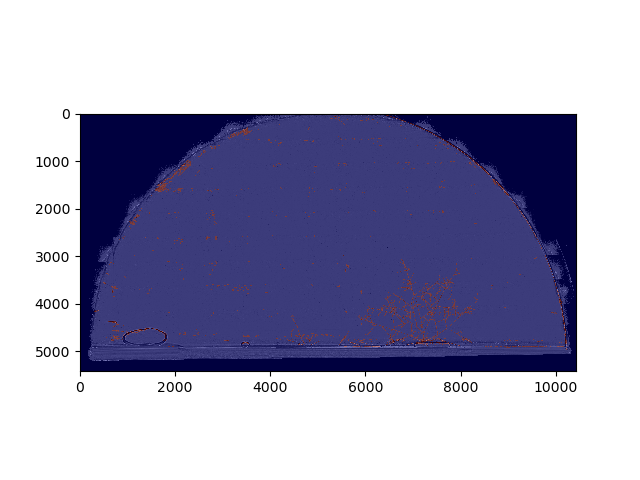

In [31]:
plt.close('all')
start = 0
finish = start + 1
for i in range(start,finish):
    plot_t_tp1([], [], None, None, skels[i]>0, ims[i])

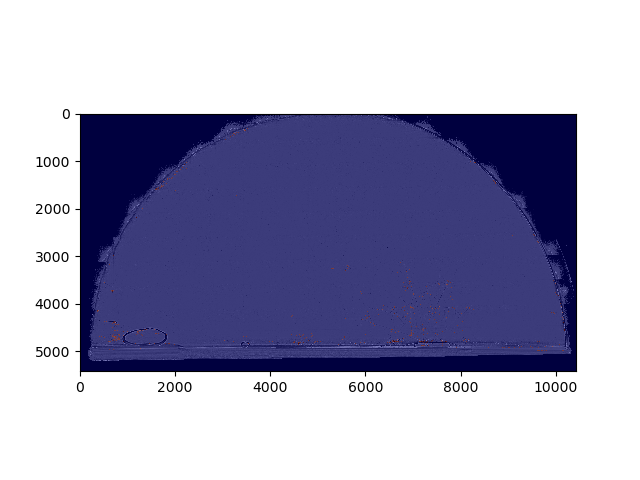

In [32]:
select = folders
folder_list = list(select['total_path'])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5,5),np.uint8)
itera = 2
start = 0

finish = start+2
for folder in folder_list[start:finish]:
    path_snap=folder
    skel_info = read_mat(path_snap+'/Analysis/skeleton_compressed2.mat')
    skel = skel_info['skeleton']
    skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))
    im = read_mat(path_snap+'/Analysis/raw_image.mat')['raw']
    ims.append(im)
plt.close('all')
start = 0
finish = start + 1
for i in range(start,finish):
    plot_t_tp1([], [], None, None, skels[i]>0, ims[i])

***These steps may be a bit long, but it also helps just keeping things consistent and use one single framework,*** you may bypass them by artificially renaming skeleton.mat into skeleton_realigned.mat which is necessary for the next step because you probably don't care about these two steps since you're doing only one image...

In [28]:
time = '2:00'
thresh = 50
args=[thresh, directory]
run_parallel('mask_skel.py',args,folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python /home/ipausers/bisot/pycode/MscThesis/amftrack/pipeline/scripts/image_processing/mask_skel.py 50 /mnt/sun-temp/TEMP/PRINCE_felix/ 1648816134424986144 0
Directory  /mnt/sun-temp/TEMP/PRINCE_felix/20220330_2357_Plate19/Analysis  already exists


In [10]:
time = '3:00:00'
threshold = 0.1
args = [threshold, directory]
run_parallel('prune_skel.py',args,folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python /home/ipausers/bisot/pycode/MscThesis/amftrack/pipeline/scripts/image_processing/prune_skel.py 0.1 /mnt/sun-temp/TEMP/PRINCE_felix/ 1650015837764351514 0
[0.19695, 0.321024, 206.3131, 0.30624, 1.282572, 0.233972]
cleaning, number of nodes before 1483
number of unsolved cases 158
number of unsolved cases 120
number of unsolved cases 110
number of unsolved cases 108
end cleaning, number of nodes after 1258


In [37]:
plates = list(set(list(folders['Plate'].values)))
for plate in plates:
    time = '2:00:00'
    args = [directory]
    run_parallel('realign.py', args, folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python /home/ipausers/bisot/pycode/MscThesis/amftrack/pipeline/scripts/image_processing/realign.py /mnt/sun-temp/TEMP/PRINCE_felix/ 1648818746428804634 0
saving 0 /mnt/sun-temp/TEMP/PRINCE_felix/20220330_2357_Plate19


Now you're finally getting to the point where you generate the graph object

In [38]:
time = '2:00:00'
args=[directory]
run_parallel('extract_nx_graph.py',args, folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python /home/ipausers/bisot/pycode/MscThesis/amftrack/pipeline/scripts/image_processing/extract_nx_graph.py /mnt/sun-temp/TEMP/PRINCE_felix/ 1648818779236444471 0
['20220330_2357_Plate19']
cleaning, number of nodes before 1056
number of unsolved cases 88
number of unsolved cases 80
number of unsolved cases 78
number of unsolved cases 78
end cleaning, number of nodes after 1019
/mnt/sun-temp/TEMP/PRINCE_felix/20220330_2357_Plate19/Analysis/nx_graph_pruned.p


***and now you have the Experiment object to play with and query images related to position of edges etc...***


In [39]:
run_info = folders
plate = int(list(run_info['folder'])[i].split('_')[-1][5:])
folder_list = list(run_info['folder'])
directory_name = folder_list[i]
exp = Experiment(plate,directory)
exp.load(run_info.loc[run_info['folder']==directory_name],labeled=False)
path_snap = directory + directory_name
(G, pos) = exp.nx_graph[0],exp.positions[0]

In [52]:
from random import choice
edge = choice(list(G.edges))

In [53]:
edge_exp = Edge(Node(edge[0],exp),Node(edge[1],exp),exp)

***Visualiser l'image correspondant à l'edge*** 

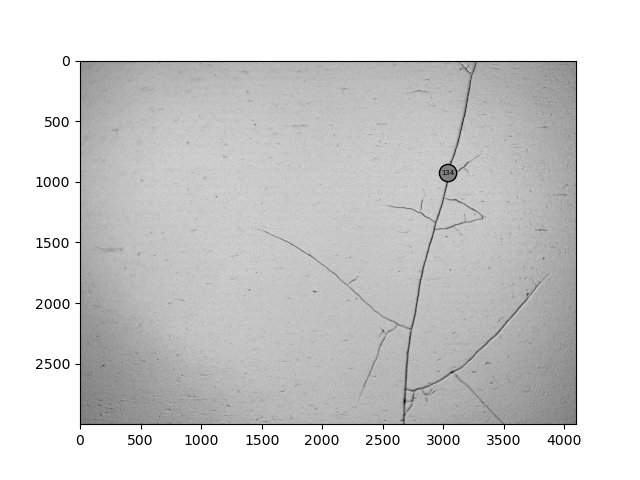

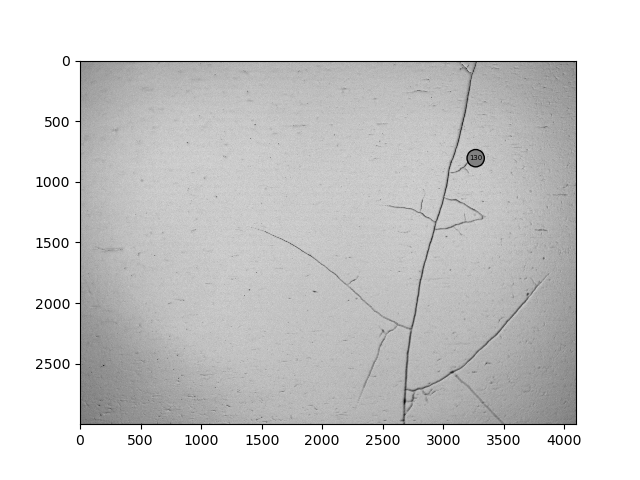

In [54]:
edge_exp.begin.show_source_image(0,0)
edge_exp.end.show_source_image(0,0)

***Visualiser tout le réseau avec l'edge idniqué dessus***

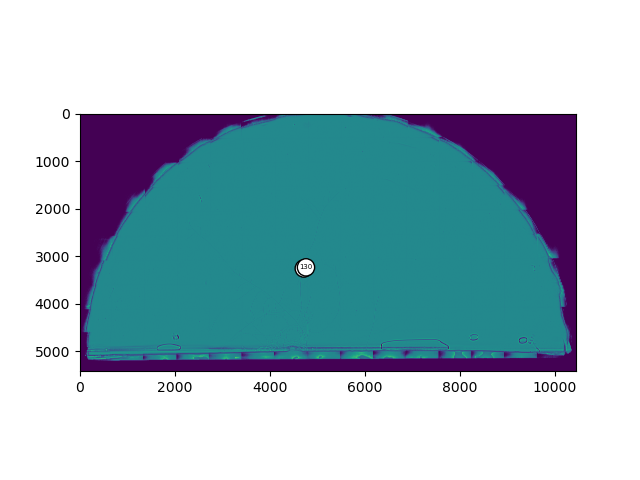

In [57]:
plot_raw_plus(exp,0,[edge_exp.begin.label,edge_exp.end.label])